## **Case study 3: Techno-economic assessment of geothermal energy for heat and power**

<p style='text-align: justify;'> Geothermal energy is a promising renewable resource for supplying both <b>heat</b> and <b>electricity</b>, offering high capacity factors, low operational emissions, and long asset lifetimes. However, the technical and economic feasibility of geothermal systems strongly depends on subsurface temperature, system configuration, and end-use requirements. In regions with medium-depth geothermal resources (<b>&lt;90&nbsp;°C</b>), these constraints become particularly relevant, as the same resource may be well suited for district heating while being unsuitable for electricity generation. </p> 

<p style='text-align: justify;'> In this case study, we apply <b>OpenPyTEA</b> to evaluate geothermal energy systems for <b>district heating</b> and <b>power generation</b>, adapted from a real-world assessment conducted by Assa et al. [1] in South Holland, the Netherlands. The study investigates alternative surface-system configurations and quantifies their technical performance and economic viability using consistent techno-economic assumptions. </p> 

<p style='text-align: justify;'> The case study is structured in two parts. We begin with a <b>geothermal district heating system</b>, comparing a conventional heat-exchanger-only configuration with a <b>geothermal system integrated with a large-scale heat pump</b>. Key performance indicators such as capital expenditures (CAPEX), operating expenditures (OPEX), levelized cost of heat (LCOH), net present value (NPV), and sensitivity to key parameters are evaluated using OpenPyTEA. In the second part, the same geothermal resource is assessed for <b>electricity generation using an Organic Rankine Cycle (ORC)</b>, highlighting the impact of resource temperature and scale on techno-economic feasibility. </p> 

<p style='text-align: justify;'> By treating heat and power generation within a unified framework, this case study demonstrates how <b>OpenPyTEA</b> enables transparent, reproducible, and comparative techno-economic analysis of geothermal energy systems, supporting informed design and investment decisions in low-carbon energy infrastructure. </p>

We start by importing <b>OpenPyTEA</b> and setting up the geothermal district heating case.

In [1]:
from openpytea.equipment import *
from openpytea.plant import *
from openpytea.analysis import *

### **Part 1: Geothermal District Heating**

<p style='text-align: justify;'> Figure 1 shows the <b>geothermal district heating configuration with integrated heat-pump upgrading</b> Heat is extracted from a medium-depth geothermal reservoir through a production well and first transferred to the district heating network via a <b>primary heat exchanger</b>. To further increase heat utilization, the remaining low-temperature geothermal heat is supplied to the <b>evaporator of a vapor-compression heat pump</b>, which upgrades the temperature to meet district heating supply requirements. After heat extraction, the cooled geothermal brine is reinjected into the reservoir through an injection well. Table 1 shows the component sizing parameters and unit counts for the geothermal district heating system. </p>

![case_study_3-figure_1](img/CS_3-Fig_1.png)
**<p style='text-align: justify; font-size: 90%;'>Figure 1.** Schematic of a geothermal district heating system with integrated vapor-compression heat pump. Geothermal brine is produced from a medium-depth reservoir and transfers heat to the district heating network through a primary heat exchanger. The remaining low-temperature geothermal heat is supplied to the evaporator of a heat pump operating in a basic vapor-compression heating cycle, increasing the temperature level of the heat delivered to the district heating network. After heat extraction, the cooled geothermal fluid is reinjected into the reservoir through an injection well.</p>

<center>
<p style="font-size: 90%;"><b>Table 1.</b> Component sizing and cost overview for the geothermal district heating system.</p>
<span style="font-size: 14px">

| **Component**                              | **Sizing parameter**   | **Number of units** | **Cost**        |
|--------------------------------------------|------------------------|---------------------|-----------------|
| **Cost of Surface Equipment**              |                        |                     |                 |
| Heat exchanger                             | 60 m²                  | 6                   |                 |
| Evaporator                                 | 286.7 m²               | 29                  |                 |
| Condenser                                  | 383.4 m²               | 39                  |                 |
| Compressor                                 | 2640.6 kW              | 1                   |                 |
| Mixers and splitters                       | Standard               | 10                  | € 40,034        |
| **Cost of Sub-surface Equipment**          |                        |                     |                 |
| ESP (Production and Injection Pumps)       | 1074.3 kW              | 2                   | € 1,281,298     |
| Separator                                  | Standard               | 1                   | € 13,200        |
| Filter                                     | Standard               | 2                   | € 619,170       |

</center>


Based on this we create we create the equipment objects with **OpenPyTEA**:

In [2]:
# Surface geothermal heat pump equipment data. Here we specify the number of units directly.
hex = Equipment(name='HEX', param=60, process_type="Fluids", category="Heat Exchangers",
                type="Plate & frame", material='Carbon steel', num_units=6)
evaporator = Equipment(name='EVAP', param=625.3, process_type="Fluids", category="Heat Exchangers",
                       type="Plate & frame", material='Carbon steel', num_units=29)
condenser = Equipment(name='COND', param=383.4, process_type="Fluids", category="Heat Exchangers",
                       type="Plate & frame", material='Carbon steel', num_units=39)
compressor = Equipment(name='COMP', param=2640.6, process_type="Fluids", category="Compressors & blowers", 
                       type="Compressor, reciprocating", material="Carbon steel")
# For mixer and splitter, since we know the purchsed cost directly, we set param=0 and specify purchased_cost.
# Since there are no information, we assume that the purchased cost is for cost year of 2023 (same as OpenPyTEA default).
mixer_n_splitter = Equipment(name='MIX_SPLIT', param=0, process_type="Fluids", category="Mixers & splitters",
                             type="Static", material="Carbon steel", num_units=10, purchased_cost=40_034*1.17) # in USD

# Subsurface geothermal heat pump equipment data
esp = Equipment(name='ESP', param=0, process_type="Fluids", category="Pumps", type="Submersible", material="Carbon steel", purchased_cost=1_281_298*1.17) # in USD
separator = Equipment(name='Separator', param=0, process_type="Fluids", category="Separators", type="Two-phase separator", material="Carbon steel", purchased_cost=13_200*1.17) # in USD
filter = Equipment(name='Filter', param=0, process_type="Fluids", category="Filters", type="Sand filter", material="Carbon steel", purchased_cost=619_170*1.17) # in USD

# Here, we create the list of the equipment for the geothermal heat pump.
geothermal_heat_pump_equipment = [
    hex,
    evaporator,
    condenser,
    compressor,
    mixer_n_splitter,
    esp,
    separator,
    filter
]

Based on the energy production and consumption shown in Figure 1, we can now create the heat pump plant object.

In [3]:
config = {'plant_name': 'Heat pump',
          'process_type': 'Fluids',   # Since there are both fluids and solids involved, we choose 'Mixed'
          'country': 'Netherlands',   # Country where the plant is located. 
          'plant_utilization': 0.83, 'interest_rate': 0.05, 'project_lifetime': 30, # Base economic assumptions
          'operator_hourly_rate': {
              'rate': 31, 'std': 10, 'max': 50, 'min': 20
          },
          'operators_hired': 3, # We follow the number of operators from the reference
          'plant_products': {  # Here we define the products and/or inputs of the plant
              'heat': {
                  'production': 25.06*1000*24, 'price': 60/1000, 'std': 20/1000, 'max': 80/1000, 'min': 40/1000
              },
            },
          'equipment': geothermal_heat_pump_equipment, 
          'variable_opex_inputs': {  # For the variable opex inputs, the consumption is always best on daily consumption
              'electricity': {
                  'consumption': (2640.6+1074.3)*24, 'price': 0.083, 'std': 0.05/2, 'max': 3, 'min': 0.01
              }
            },
}
geothermal_heat_pump = Plant(config)  # Create the process plant object. Here we name it 'geothermal_heat_pump'

<p style='text-align: justify;'> When modeling geothermal plants, several additional capital cost components must be considered beyond direct equipment costs, OSBL costs, and design and engineering contingency costs. These costs are associated with the exploration, drilling, and field development of the geothermal wells, shown in Table 2. They typically represent a significant share of the total project investment and are therefore essential to include in a comprehensive techno-economic assessment.</p>

<center>
<p style="font-size: 90%;"><b>Table 2.</b> Drilling, exploration, and field development capital costs for the geothermal heating system.</p>
<span style="font-size: 14px">

| **Drilling and Field Development** | **Specification** | **Cost**        |
|-----------------------------------|-------------------|-----------------|
| Drilling and wells                | 2162.0 m          | € 9,576,726     |
| Field gathering cost              | —                 | € 2,546,841     |
| Exploration costs                 | —                 | € 3,706,741     |
| **Total Drilling & Connection**   |                   | **€ 15,830,308** |

</center>


<p style='text-align: justify;'> To include these costs in the plant cash flow, we can make use of the `additional_capex_cost` and `additional_capex_years` configurations. These costs are generally incurred in the very beginning of a geothermal project, thus hear we specify the `additional_capex_years` as Year 1:</p>

In [4]:
drilling_n_well = 9_576_726 # Cost for drilling and completing wells, in USD
field_gathering = 2_546_841 # Cost for field gathering, in USD
exploration_cost = 3_706_741 # Cost for exploration activities, in USD

geothermal_heat_pump.update_configuration({'additional_capex_cost': [drilling_n_well, field_gathering, exploration_cost], 'additional_capex_years': [1,1,1]})
# Let's check this by calculating fixed capital cost and printing the cash flow details
geothermal_heat_pump.calculate_fixed_capital(print_results=True, additional_capex=True)  # To print out the additional capex details, we set additional_capex=True
geothermal_heat_pump.calculate_cash_flow(print_results=True)

Capital cost estimation
ISBL: $16,619,137.46
OSBL: $4,985,741.24
Design and engineering: $6,481,463.61
Contingency: $2,160,487.87
Additional CAPEX: $15,830,308.00
Fixed capital investment: $46,077,138.19


,Year,Capital cost,Revenue,Cash cost,Gross profit,Depreciation,Taxable income,Tax paid,Cash flow
0,1,"$24,904,357.06",$0.00,"$2,941,802.08","$-2,941,802.08",$0.00,"$-2,941,802.08",$0.00,"$-27,846,159.13"
1,2,"$18,148,098.11",$0.00,"$2,941,802.08","$-2,941,802.08",$0.00,"$-2,941,802.08",$0.00,"$-21,089,900.19"
2,3,"$7,561,707.55","$4,372,949.95","$3,838,543.87","$534,406.09","$2,016,455.35","$-1,482,049.26",$0.00,"$-7,027,301.46"
3,4,$0.00,"$8,745,899.90","$4,735,285.66","$4,010,614.25","$2,016,455.35","$1,994,158.90",$0.00,"$4,010,614.25"
4,5,$0.00,"$10,932,374.88","$5,183,656.55","$5,748,718.33","$2,016,455.35","$3,732,262.98",$0.00,"$5,748,718.33"
5,6,$0.00,"$10,932,374.88","$5,183,656.55","$5,748,718.33","$2,016,455.35","$3,732,262.98",$0.00,"$5,748,718.33"
6,7,$0.00,"$10,932,374.88","$5,183,656.55","$5,748,718.33","$2,016,455.35","$3,732,262.98",$0.00,"$5,748,718.33"
7,8,$0.00,"$10,932,374.88","$5,183,656.55","$5,748,718.33","$2,016,455.35","$3,732,262.98",$0.00,"$5,748,718.33"
8,9,$0.00,"$10,932,374.88","$5,183,656.55","$5,748,718.33","$2,016,455.35","$3,732,262.98",$0.00,"$5,748,718.33"
9,10,$0.00,"$10,932,374.88","$5,183,656.55","$5,748,718.33","$2,016,455.35","$3,732,262.98",$0.00,"$5,748,718.33"


To see how significant the additional drilling and exploration costs to the overall investment, we can plot the breakdown of the fixed capital costs with the actual value and percentage-wise using the following function:

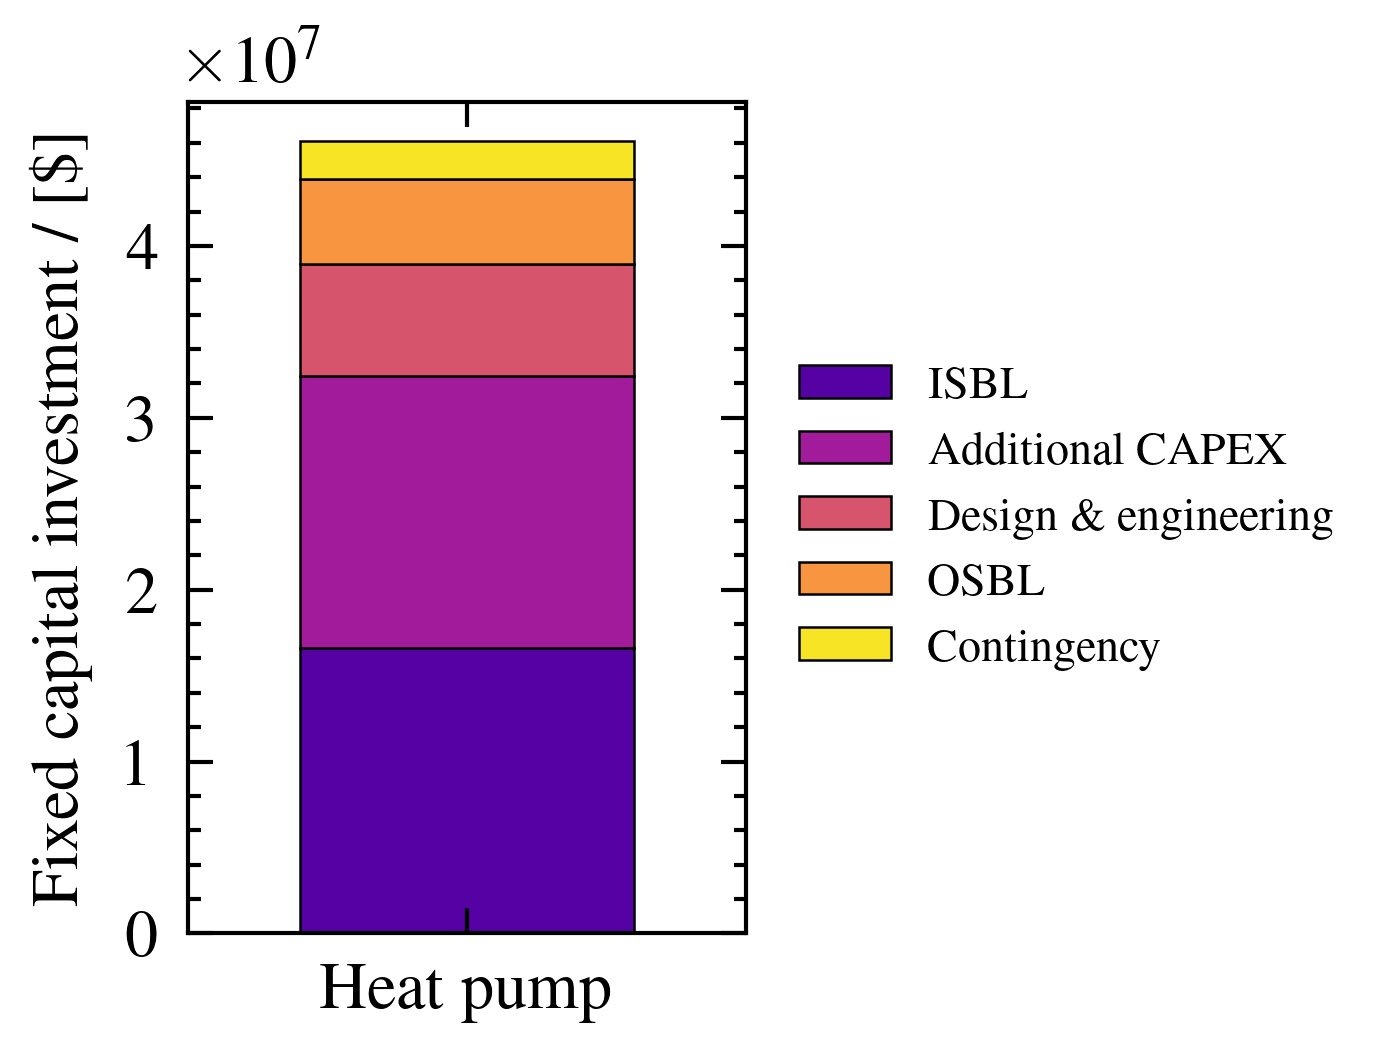

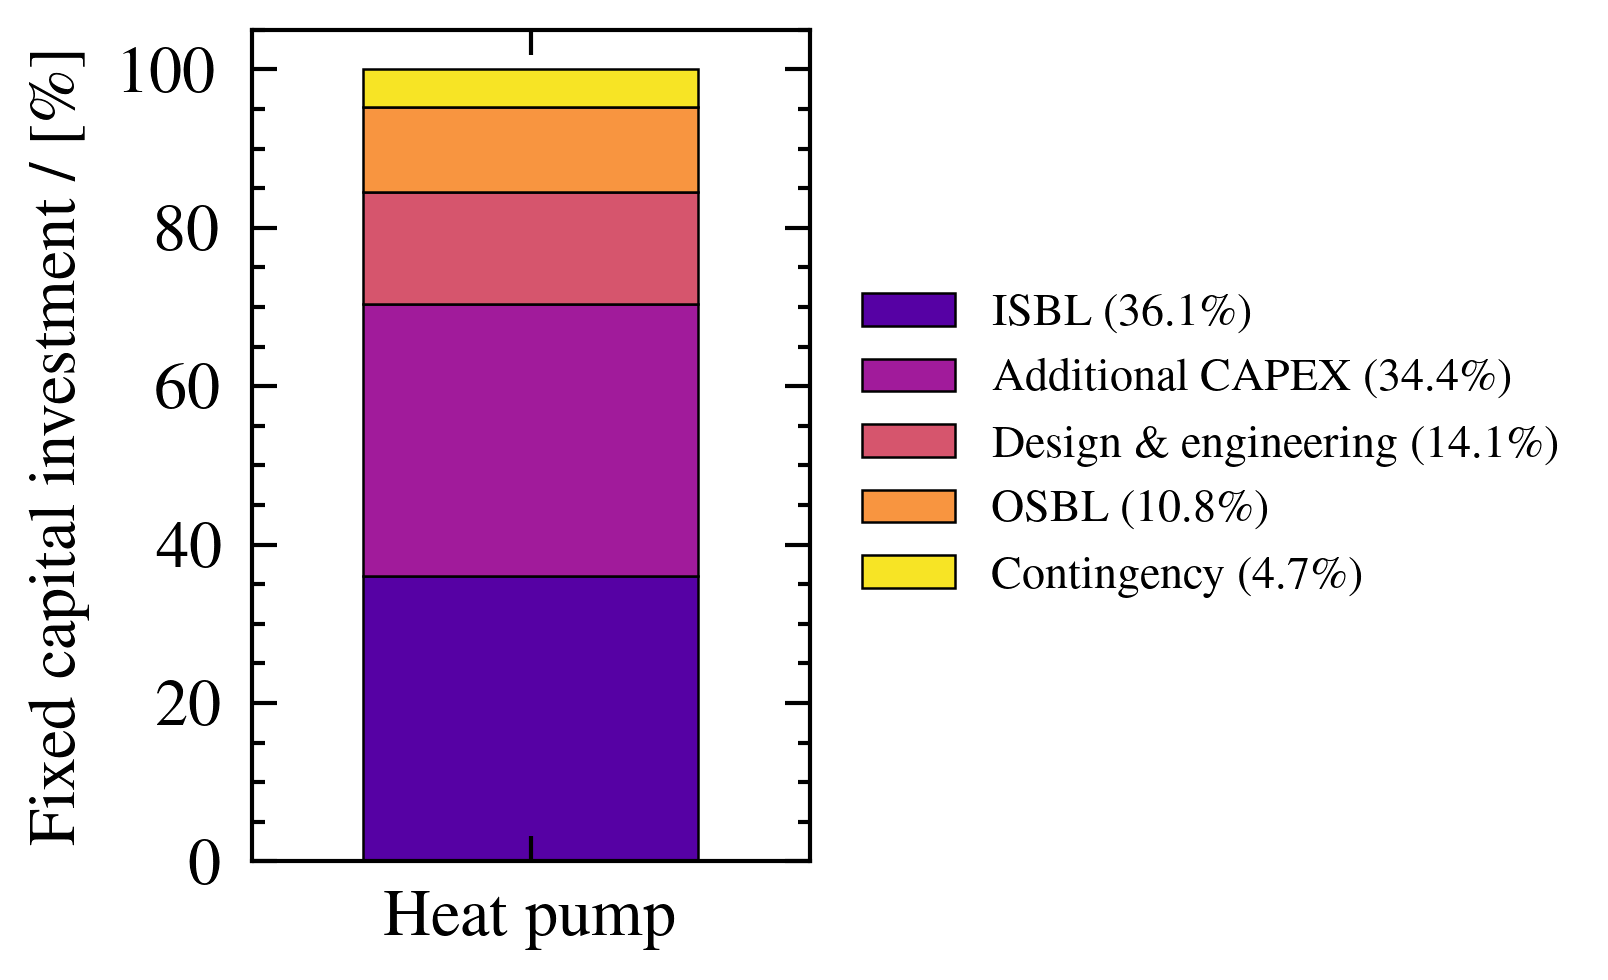

In [5]:
plot_fixed_capital_bar(geothermal_heat_pump, additional_capex=True)  # To include additional capex in the bar plot, we need to set additional_capex=True
plot_fixed_capital_bar(geothermal_heat_pump, additional_capex=True, pct=True)  # To show the bar chart as percentages, we set pct=True

In the cash flow table, we already observe positive cash flows starting from Year 4. To ensure that the project is truly profitable, even when accounting for the time value of money at a fixed discount rate, we evaluate the net present value (NPV). The NPV must be positive by the end of the project lifetime. For completeness, we calculate all relevant economic performance metrics below.

In [6]:
geothermal_heat_pump.calculate_levelized_cost(print_results=True)
geothermal_heat_pump.calculate_payback_time(print_results=True, additional_capex=True)  # To include additional capex in the payback time, we need to set additional_capex=True
geothermal_heat_pump.calculate_roi(print_results=True, additional_capex=True)  # To include additional capex in the ROI, we need to set additional_capex=True
geothermal_heat_pump.calculate_irr(print_results=True)
geothermal_heat_pump.calculate_npv(print_results=True)

Levelized cost: $0.051/unit
Payback time: 8.54 years
Return of investment: 9.76%
Internal Rate of Return: 7.93%
Year | Present Value (PV) | Cumulative NPV
-------------------------------------------
   1 | $ -26,520,151.55 | $ -26,520,151.55
   2 | $ -19,129,161.17 | $ -45,649,312.72
   3 | $  -6,070,447.22 | $ -51,719,759.94
   4 | $   3,299,542.27 | $ -48,420,217.67
   5 | $   4,504,271.23 | $ -43,915,946.44
   6 | $   4,289,782.13 | $ -39,626,164.31
   7 | $   4,085,506.79 | $ -35,540,657.53
   8 | $   3,890,958.84 | $ -31,649,698.68
   9 | $   3,705,675.09 | $ -27,944,023.59
  10 | $   3,529,214.37 | $ -24,414,809.22
  11 | $   3,361,156.54 | $ -21,053,652.68
  12 | $   3,201,101.47 | $ -17,852,551.20
  13 | $   3,048,668.07 | $ -14,803,883.14
  14 | $   2,903,493.40 | $ -11,900,389.74
  15 | $   2,765,231.81 | $  -9,135,157.93
  16 | $   2,633,554.10 | $  -6,501,603.83
  17 | $   2,508,146.76 | $  -3,993,457.07
  18 | $   2,388,711.20 | $  -1,604,745.86
  19 | $   2,274,963.05 | $

Now let’s evaluate the sensitivity of these metrics as a function of the heat selling price. This is an important step that helps quantify price risk and determine the range of heat prices over which the project remains economically viable.

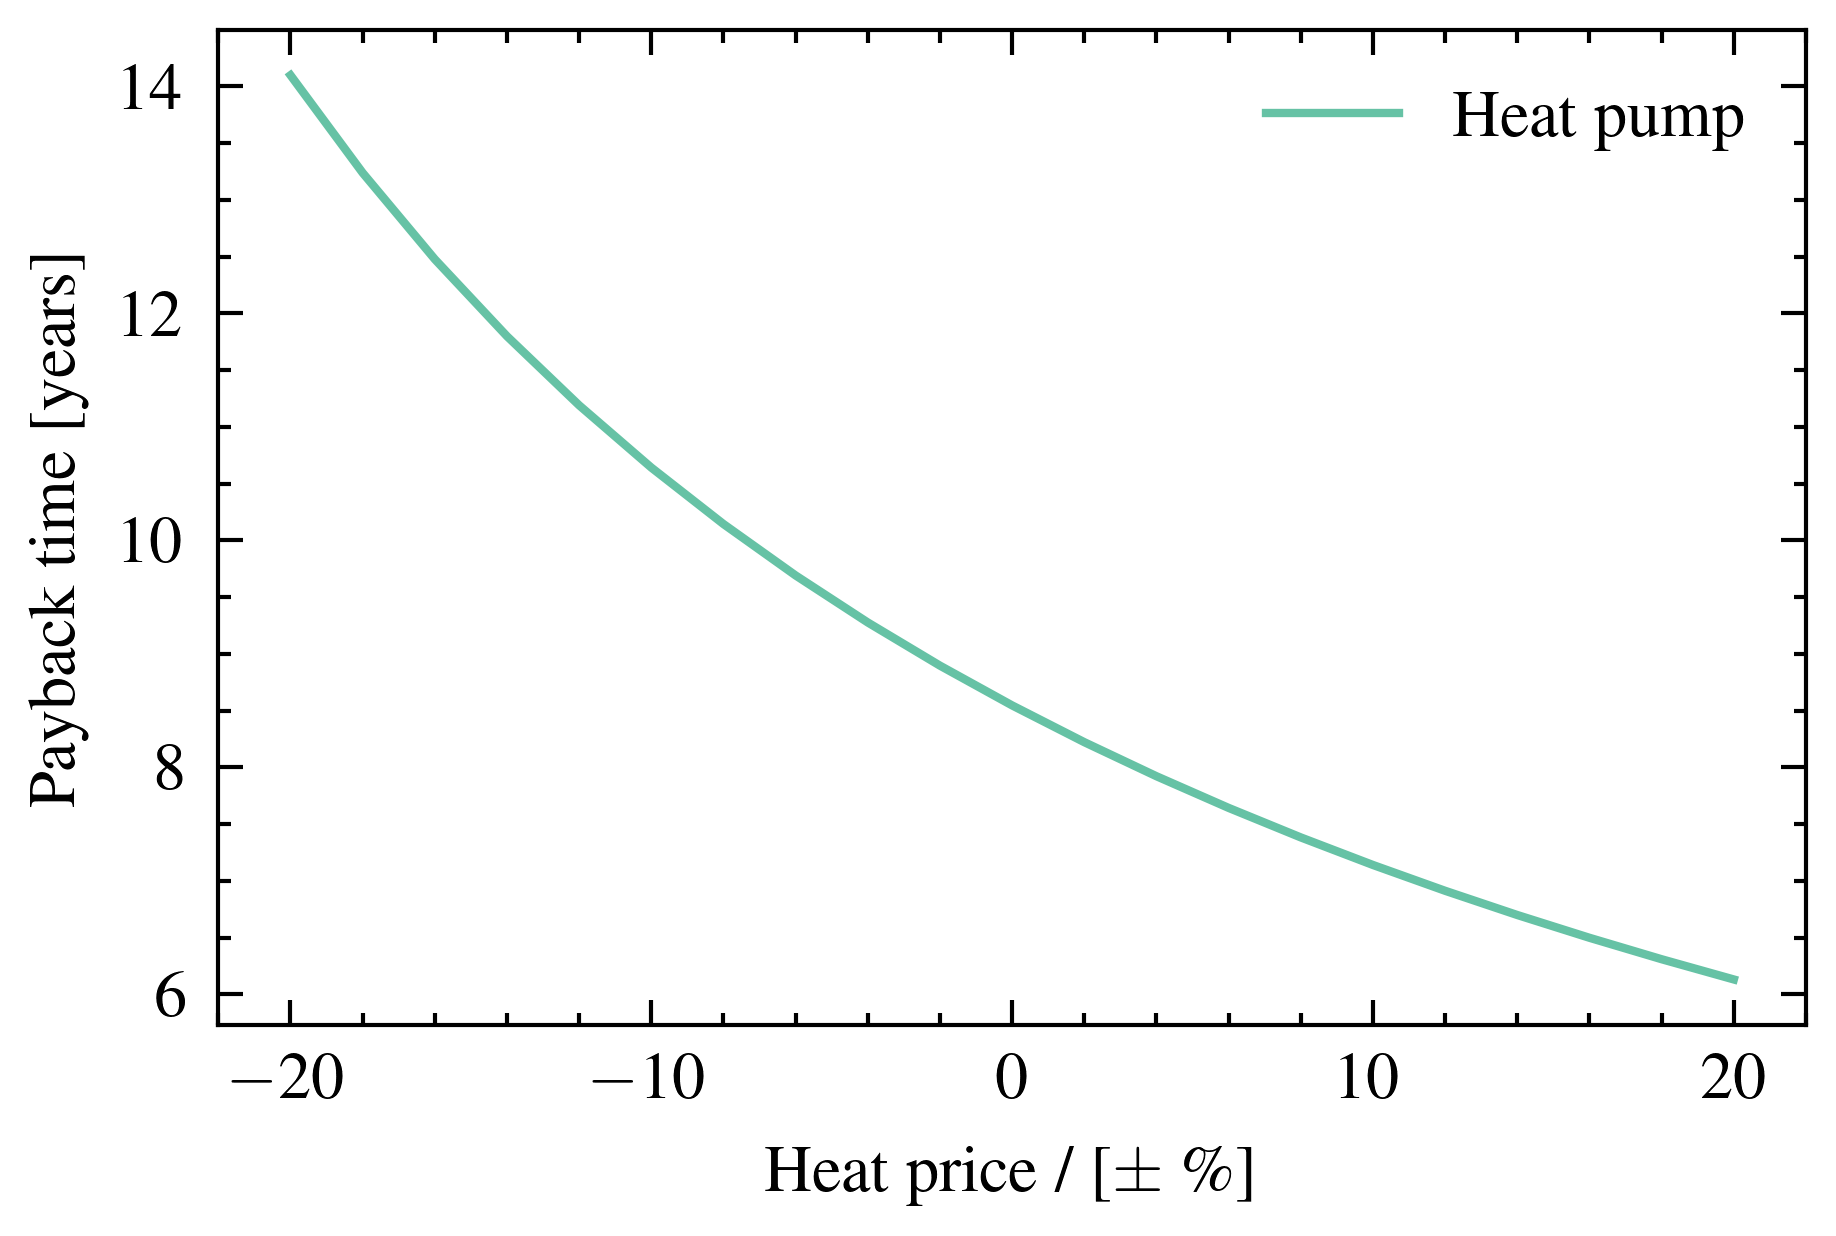

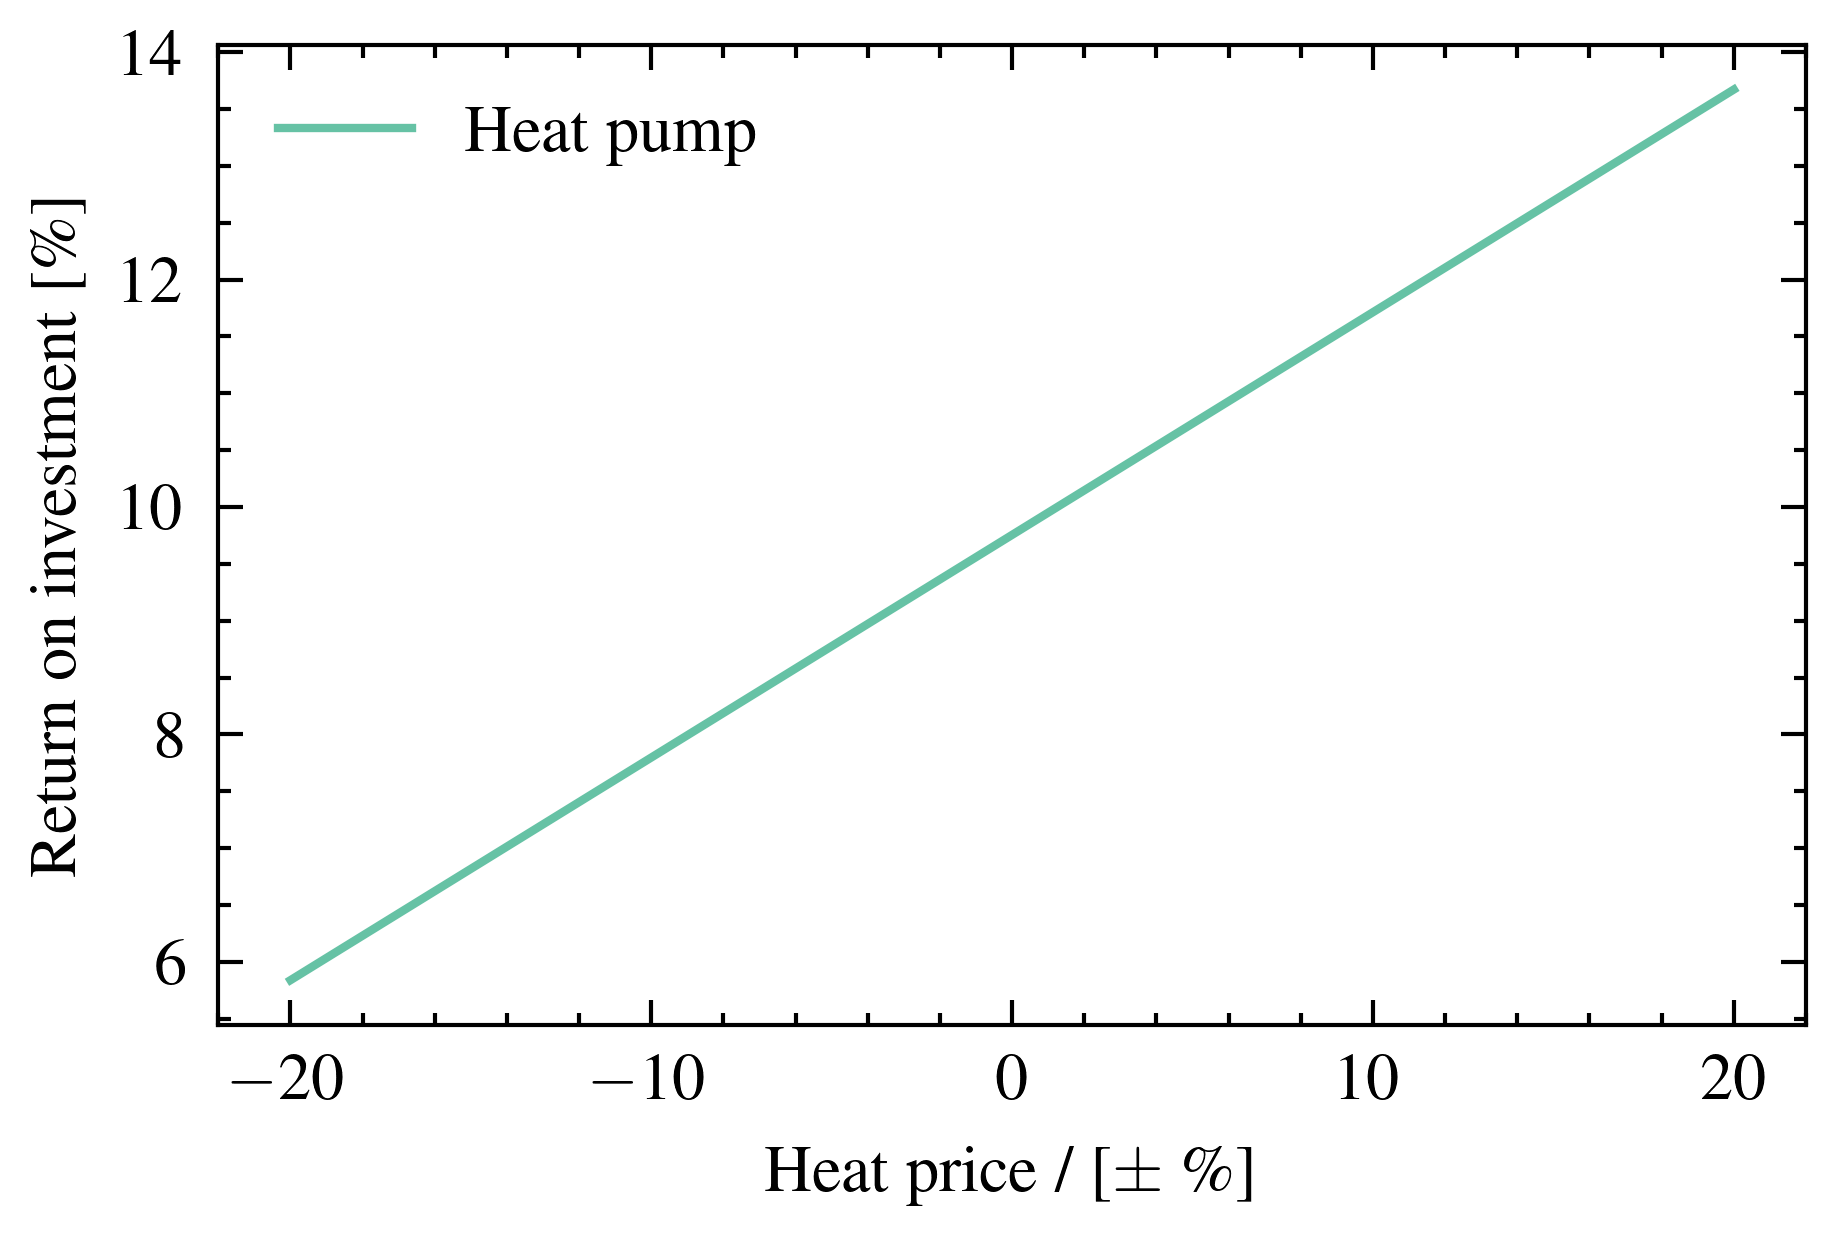

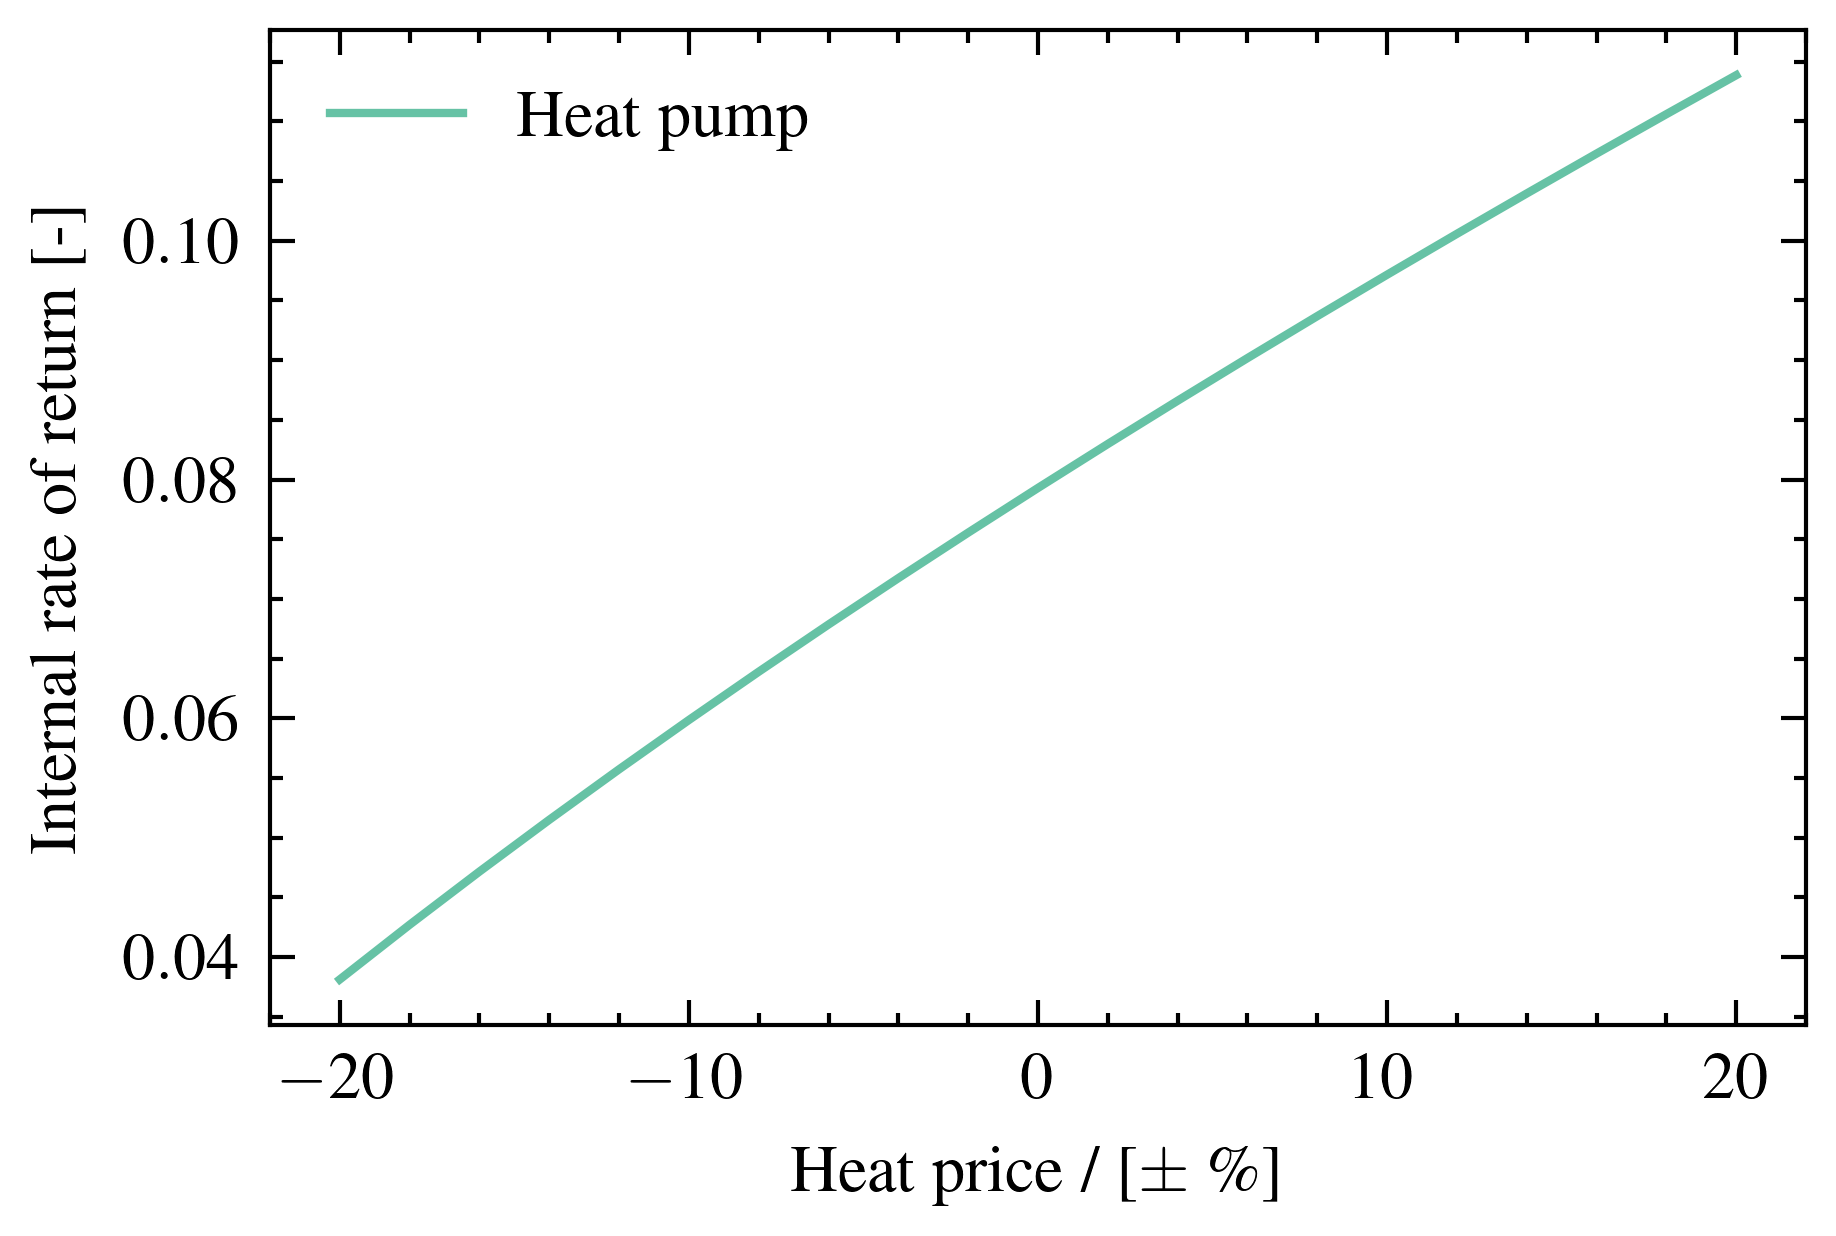

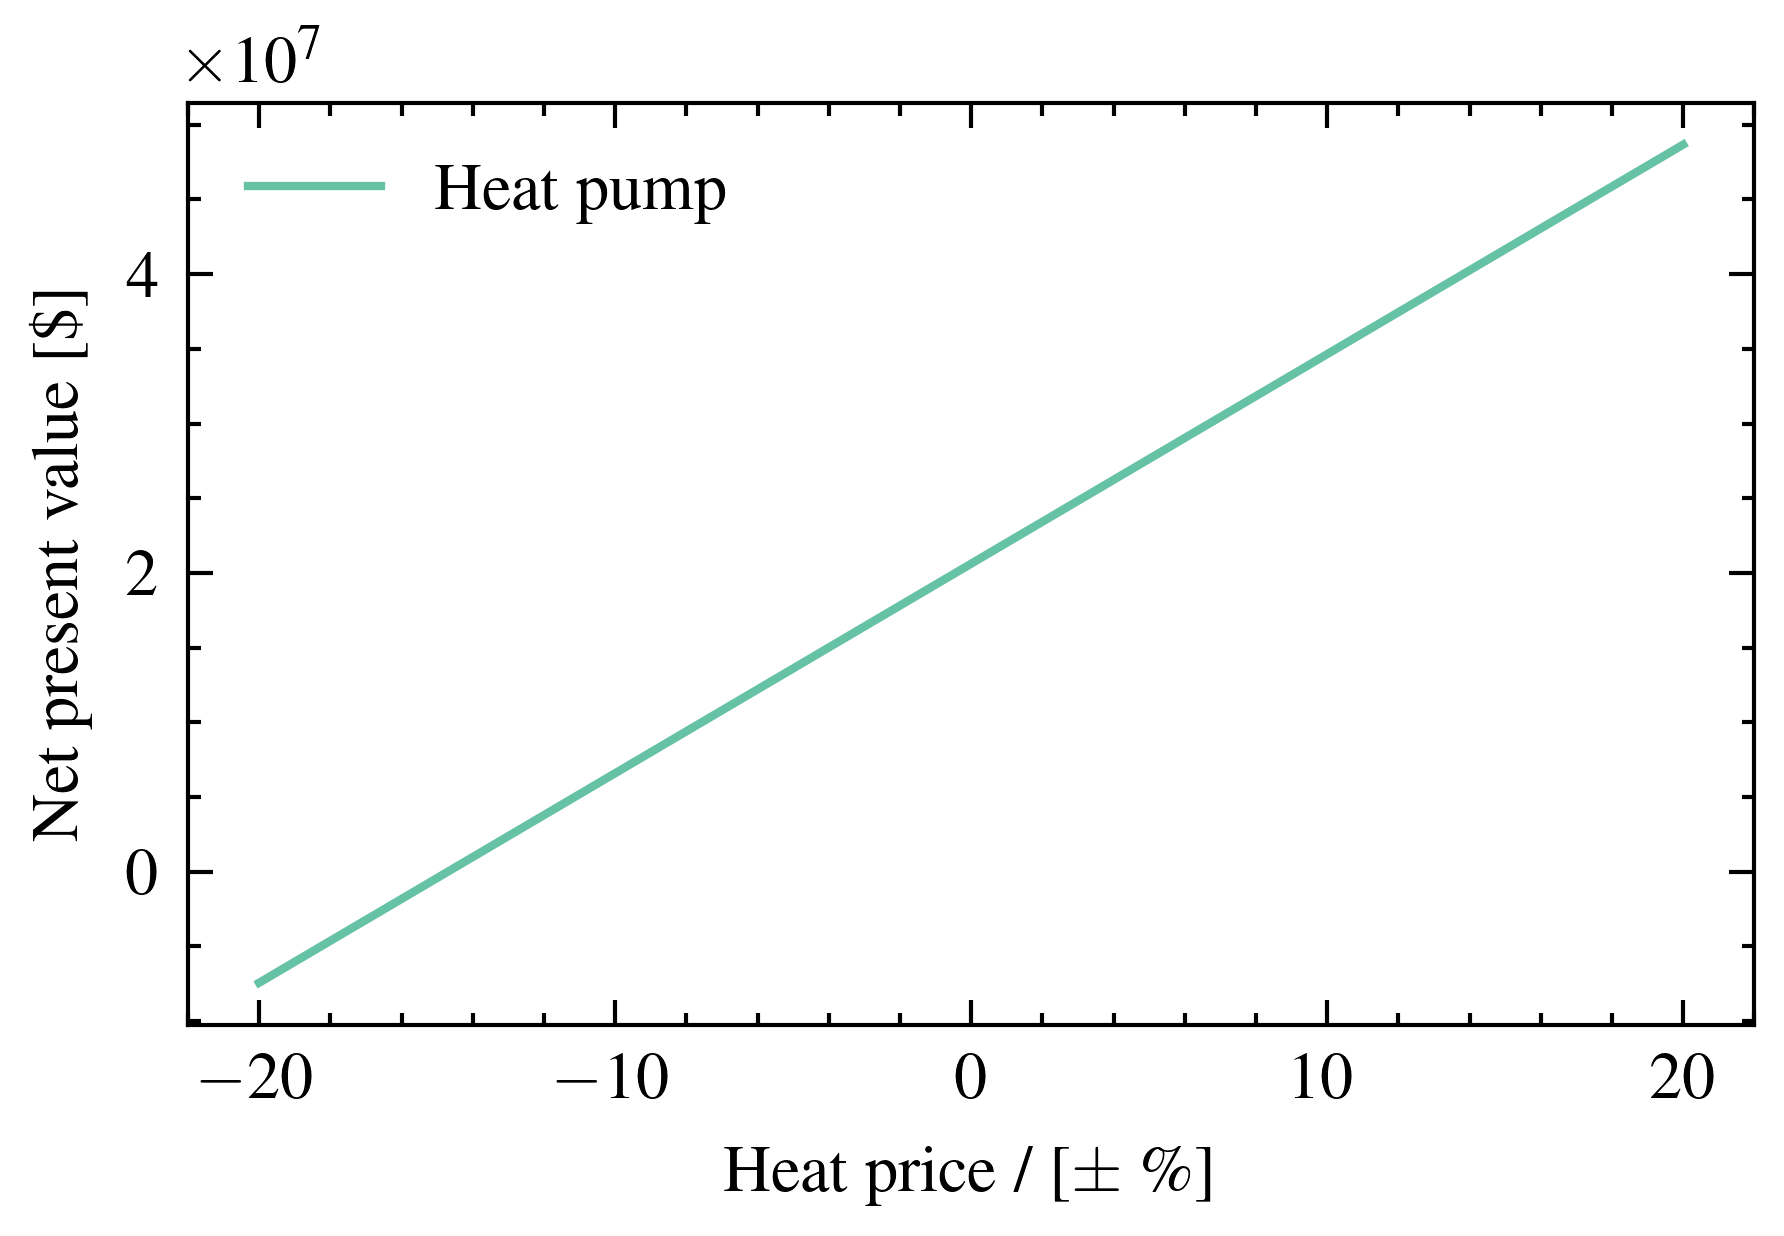

In [7]:
# LCOP is not calculated here since it is insensitive to product sales
sensitivity_plot(geothermal_heat_pump,'heat', 0.2, metric="PBT", additional_capex=True) # To include additional capex in the PBT sensitivity, we need to set additional_capex=True
sensitivity_plot(geothermal_heat_pump,'heat', 0.2, metric="ROI", additional_capex=True) # To include additional capex in the ROI sensitivity, we need to set additional_capex=True
sensitivity_plot(geothermal_heat_pump,'heat', 0.2, metric="IRR")
sensitivity_plot(geothermal_heat_pump,'heat', 0.2, metric="NPV")

We see here that the project becomes unprofitable at around -15% of the heat price, i.e. 0.051 kWh/$, which is around the levelized cost of heating.

Now let’s perform a tornado plot and a Monte Carlo analysis on the project NPV to identify the most influential economic parameters and quantify the uncertainty in project profitability.

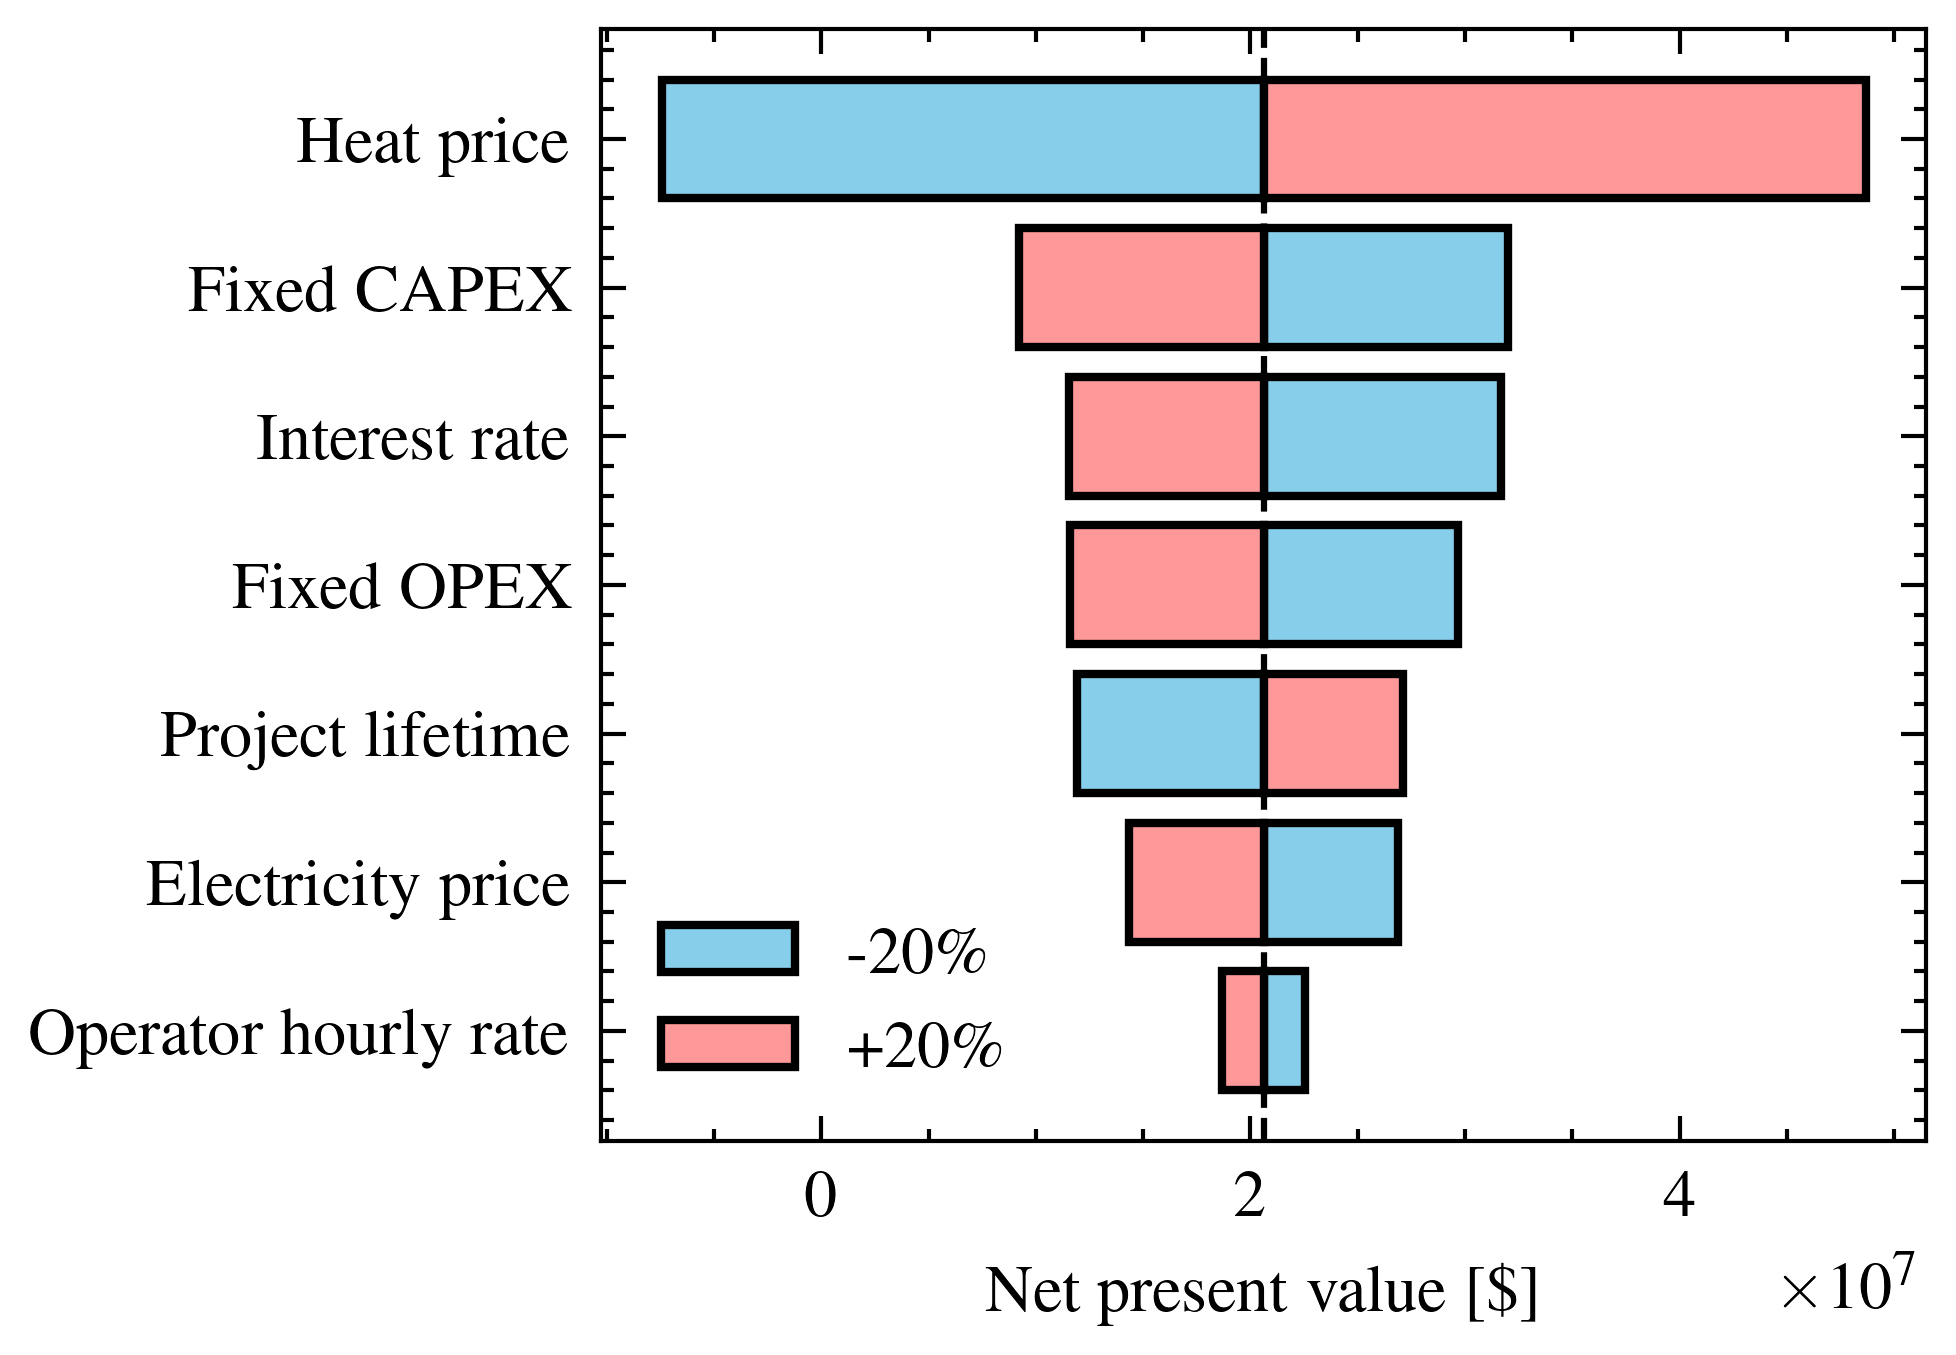

In [8]:
tornado_plot(geothermal_heat_pump, 0.2, 'npv')

In [9]:
monte_carlo(geothermal_heat_pump)

Monte Carlo: 100%|██████████| 1000/1000 [01:18<00:00, 12.68it/s]


({'LCOP': array([0.04911192, 0.04911192, 0.04911192, ..., 0.04880279, 0.04880279,
         0.04880279], shape=(1000000,)),
  'ROI': array([18.32877512, 26.3778454 , 25.98920405, ..., 16.72659108,
         15.82235224, 26.99483892], shape=(1000000,)),
  'NPV': array([-24297646.27648141,   7596648.0682235 ,  37081715.28197728, ...,
          27045156.81895787,  63132223.79772448, -53536249.15249032],
        shape=(1000000,)),
  'PBT': array([4.77459226, 7.12422039, 4.17622103, ..., 7.22598279, 4.8272794 ,
         6.53020966], shape=(1000000,))},
 {'Fixed capital factor': array([0.85517931, 1.27602223, 0.74800478, ..., 1.30221058, 0.86993486,
         1.17682375], shape=(1000000,)),
  'Fixed opex factor': array([1.09964982, 0.83529894, 0.84452184, ..., 0.96622288, 1.03609758,
         1.57103083], shape=(1000000,)),
  'Operator hourly rate': array([35.14469669, 29.65821915, 21.26474117, ..., 33.39364468,
         23.97787847, 28.2021304 ], shape=(1000000,)),
  'Project lifetime': array(

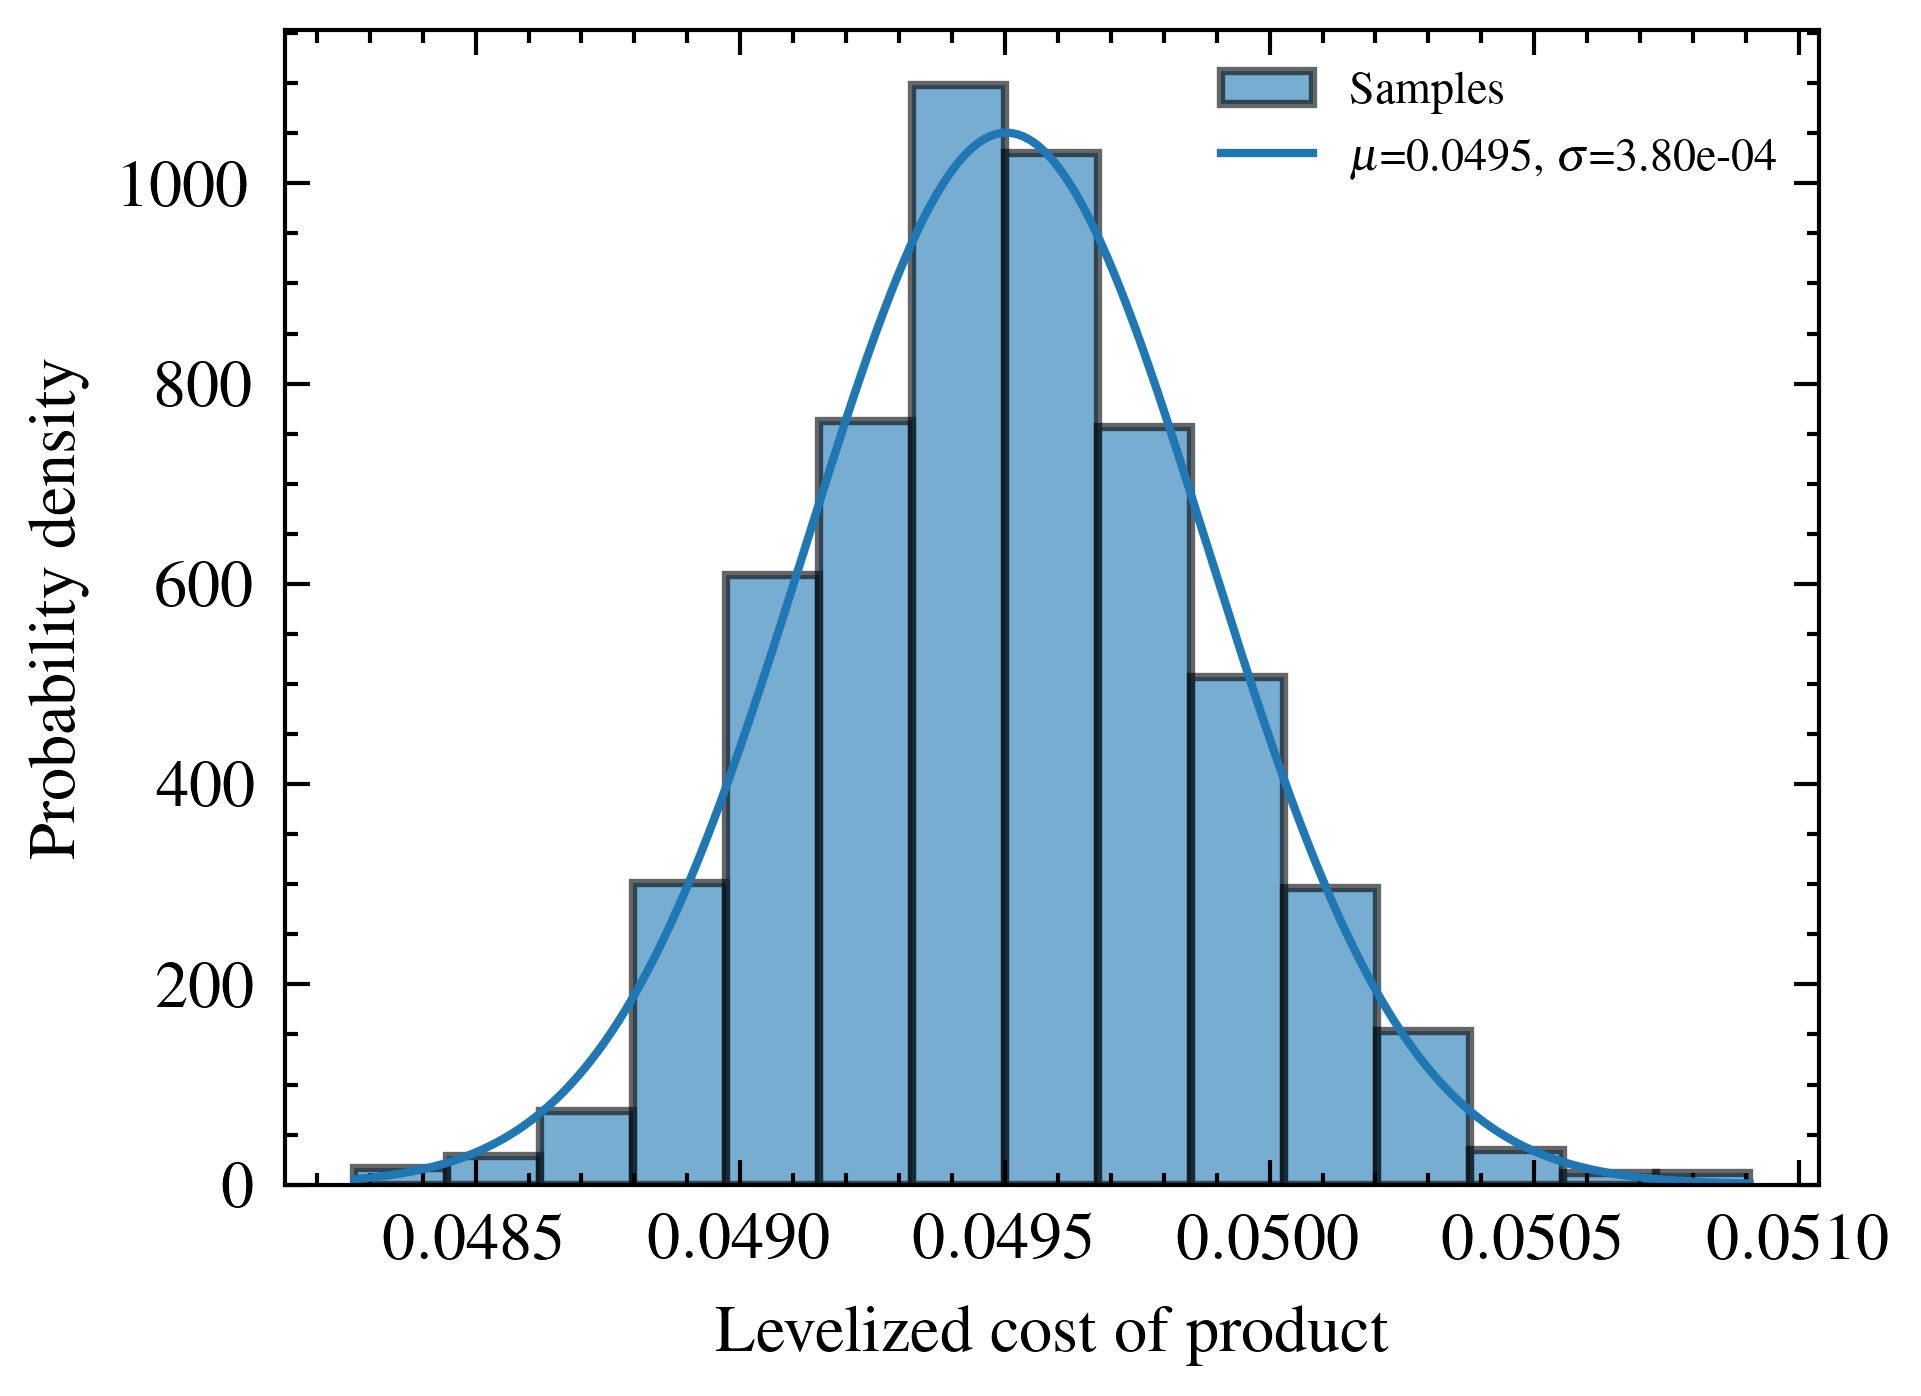

In [10]:
plot_monte_carlo(geothermal_heat_pump, bins=15, metric="LCOP")

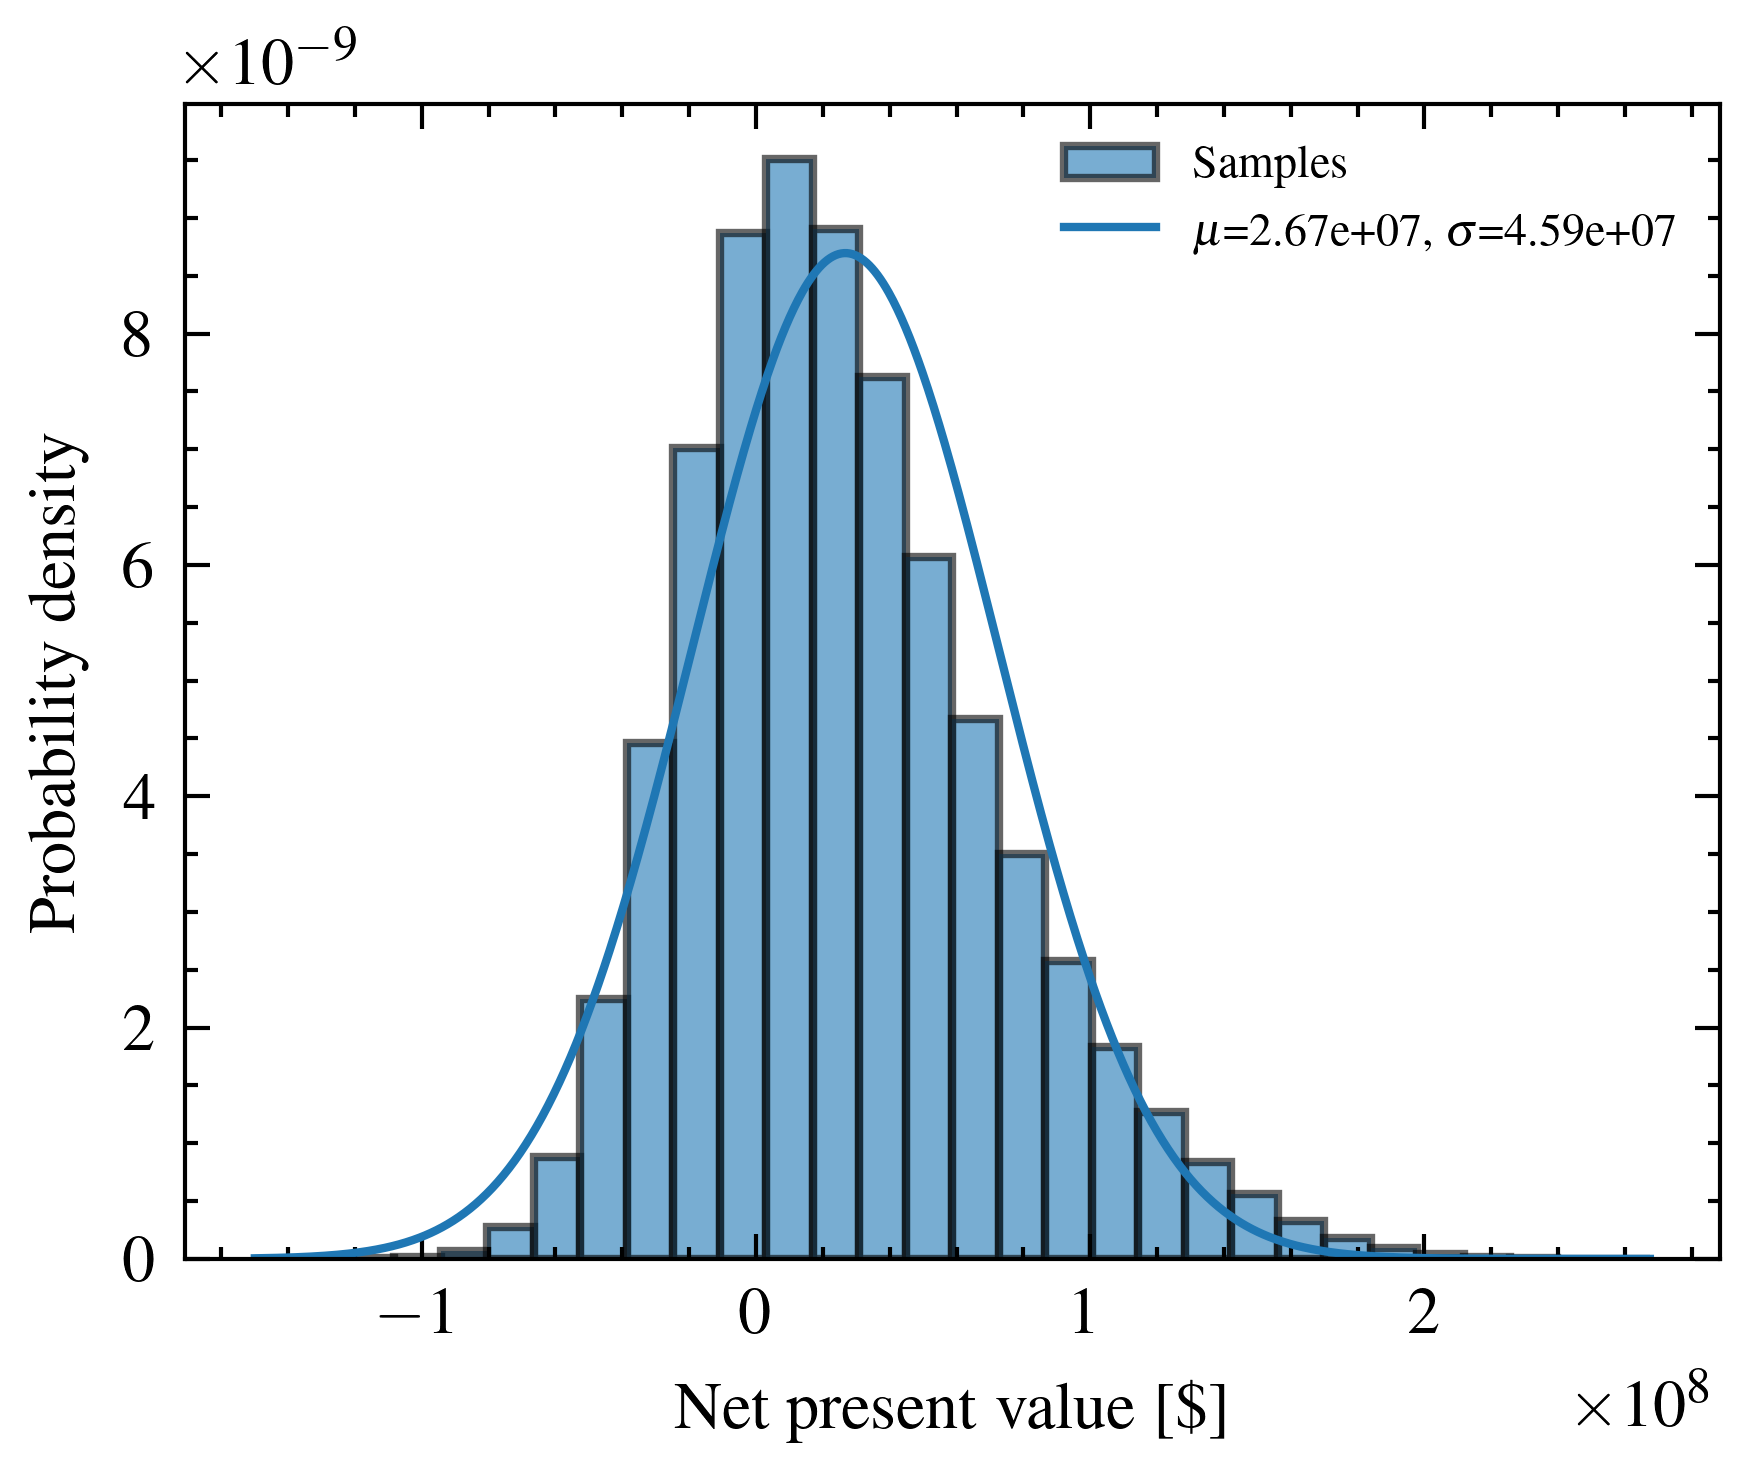

In [11]:
plot_monte_carlo(geothermal_heat_pump, bins=30, metric="NPV")

The Monte Carlo analysis indicates that the levelized cost of heat is relatively stable, with relatively small dispersion around its mean value. The majority of the NPV outcomes are still positive, suggesting a likelihood of economic viability. However, there are still substantial risks of negative NPV outcomes under unfavorable combinations of market conditions and cost assumptions; therefore, careful attention should be given to heat price setting, cost control, and risk mitigation strategies during project development.

### **Part 2: Geothermal Power Plant**

<p style='text-align: justify;'>In the second part of this case study, we assess the feasibility of using the same geothermal resource for <b>electricity generation</b> Power production from medium-depth, low-temperature geothermal sources typically requires the use of an <b>Organic Rankine Cycle (ORC)</b>, which enables electricity generation from heat sources below the boiling point of water, by means of using organic working fluids with favorable thermophysical properties at low temperatures. Using <b>OpenPyTEA</b>, we model a geothermal power plant based on an ORC configuration and highlights the limitations of low-enthalpy geothermal resources for power generation compared to the district heating application discussed in Part 1.</p>

<p style='text-align: justify;'>Figure 2 shows the schematic of a geothermal power plant based on an ORC system. Geothermal brine is produced from the reservoir and transfers heat to the ORC evaporator, driving a closed-loop cycle consisting of a pump, evaporator, expander, and condenser. Electricity is generated in the expander and exported to the grid, after which the geothermal fluid is reinjected into the reservoir. This configuration represents a standard approach for power generation from low-temperature geothermal resources and forms the basis of the techno-economic analysis. Table 3 shows the component sizing parameters and unit counts for the geothermal ORC plant.</p>

![case_study_3-figure_2](img/CS_3-Fig_2.png)
**<p style='text-align: justify; font-size: 90%;'>Figure 2.** Conceptual layout of an ORC-based geothermal power plant. Heat extracted from the geothermal production well is used to vaporize an organic working fluid in the evaporator, enabling electricity generation in the expander. The working fluid is subsequently condensed using an external heat sink and recirculated within the cycle, while the cooled geothermal brine is reinjected into the subsurface.</p>

<center>
<p style="font-size: 90%;"><b>Table 3.</b> Component sizing and cost overview for the geothermal ORC plant.</p>
<span style="font-size: 14px">

| **Component**                              | **Sizing parameter**   | **Number of units** | **Cost**        |
|--------------------------------------------|------------------------|---------------------|-----------------|
| **Cost of Surface Equipment**              |                        |                     |                 |
| Evaporator                                 | 150.1 m²               | 1                   |                 |
| Condenser                                  | 625.3 m²               | 1                   |                 |
| Pump                                       | 15.8 kW                | 1                   |                 |
| Expander                                   | 952.9 kW               | 1                   |                 |
| **Cost of Sub-surface Equipment**          |                        |                     |                 |
| ESP (Production and Injection Pumps)       | 1099.6 kW              | 2                   | € 1,299,323     |
| Separator                                  | Standard               | 1                   | € 13,200        |
| Filter                                     | Standard               | 2                   | € 619,170       |

</center>

Now we can create the `Equipment` objects for the ORC plant:

In [12]:
# Surface geothermal heat pump equipment data. Here we specify the number of units directly.
evaporator = Equipment(name='EVAP', param=150.1, process_type="Fluids", category="Heat Exchangers",
                       type="Plate & frame", material='Carbon steel')
condenser = Equipment(name='COND', param=625.3, process_type="Fluids", category="Heat Exchangers",
                       type="Plate & frame", material='Carbon steel')
pump = Equipment(name='PUMP', param=2640.6, process_type="Fluids", category="Pumps", 
                       type="Centrifugal pump", material="Carbon steel")
expander = Equipment(name='TURB', param=952.9, process_type="Fluids", category="Turbines", 
                       type="Radial expander", material="Carbon steel")


# Subsurface geothermal heat pump equipment data
# Since there are no information, we assume that the purchased cost is for cost year of 2024 (same as OpenPyTEA default).
esp = Equipment(name='ESP', param=0, process_type="Fluids", category="Pumps", type="Submersible", material="Carbon steel", purchased_cost=1_299_323*1.17) # in USD
separator = Equipment(name='Separator', param=0, process_type="Fluids", category="Separators", type="Two-phase separator", material="Carbon steel", purchased_cost=13_200*1.17) # in USD
filter = Equipment(name='Filter', param=0, process_type="Fluids", category="Filters", type="Sand filter", material="Carbon steel", purchased_cost=619_170*1.17) # in USD

# Here, we create the list of the equipment for the geothermal heat pump.
geothermal_power_plant_equipment = [
    evaporator,
    condenser,
    pump,
    expander,
    esp,
    separator,
    filter
]

Based on the energy production and consumption shown in Figure 2, we can now create the geothermal-ORC power plant object.

<p style='text-align: justify;'>Note: We can already observe that the plant is not expected to be profitable, as the power consumption exceeds the electricity produced. However, to demonstrate how <b>OpenPyTEA</b> handles unprofitable cases, we proceed with the analysis. </p>

In [13]:
config = {'plant_name': 'Power plant',
          'process_type': 'Fluids',   # Since there are both fluids and solids involved, we choose 'Mixed'
          'country': 'Netherlands',   # Country where the plant is located. 
          'plant_utilization': 0.83, 'interest_rate': 0.05, 'project_lifetime': 30, # Base economic assumptions
          'operator_hourly_rate': {
              'rate': 31, 'std': 10, 'max': 50, 'min': 20
          },
          'operators_hired': 3, # We follow the number of operators from the reference
          'plant_products': {  # Here we define the products and/or inputs of the plant
              'power': {
                  'production': 952.9*24, 'price': 0.083, 'std': 0.05/2, 'max': 3, 'min': 0.01
              },
            },
          'equipment': geothermal_power_plant_equipment, 
          'variable_opex_inputs': {  # For the variable opex inputs, the consumption is always best on daily consumption
              'electricity': {
                  'consumption': (15.8+1099.6)*24, 'price': 0.083, 'std': 0.05/2, 'max': 3, 'min': 0.01
              }
            },
}
geothermal_power_plant = Plant(config)  # Create the process plant object. Here we name it 'geothermal_heat_pump'

<p style='text-align: justify;'>
As with the geothermal heat pump case, several additional capital cost components must be considered when modeling a geothermal power plant. In addition to the exploration, drilling, and field development costs of the geothermal wells, the power generation case also includes an additional cost associated with the <b>connection to the electricity grid</b>.
</p>

<center>
<p style="font-size: 90%;"><b>Table 4.</b> Drilling, exploration, field development, and grid connection capital costs for the geothermal power plant.</p>
<span style="font-size: 14px">

| **Drilling and Field Development** | **Specification** | **Cost**        |
|-----------------------------------|-------------------|----------------|
| Drilling and wells                | 2162.0 m          | € 8,576,733    |
| Field gathering cost              | —                 | € 1,639,527    |
| Exploration costs                 | —                 | € 2,700,451    |
| Grid connection                   | —                 | € 1,500,000    |
| **Total Drilling & Connection**   |                   | **€ 17,416,711** |

</span>
</center>

<p style='text-align: justify;'>
As in the geothermal heat pump case, these costs are included in the cash flow using the
<code>additional_capex_cost</code> and <code>additional_capex_years</code> configurations, with all costs incurred in Year&nbsp;1 of the project.
</p>

In [14]:
drilling_n_well = 9_576_733 # Cost for drilling and completing wells, in USD
field_gathering = 2_639_527 # Cost for field gathering, in USD
exploration_cost = 3_700_451 # Cost for exploration activities, in USD
connection_2_grid = 1_500_000 # Cost for connection to the grid, in USD

geothermal_power_plant.update_configuration({'additional_capex_cost': [drilling_n_well, field_gathering, exploration_cost, connection_2_grid], 'additional_capex_years': [1,1,1,1]})


Now let's print out the cash flow and other economic indicators for the geothermal power plant

In [15]:
geothermal_power_plant.calculate_cash_flow(print_results=True)

,Year,Capital cost,Revenue,Cash cost,Gross profit,Depreciation,Taxable income,Tax paid,Cash flow
0,1,"$25,210,580.46",$0.00,"$2,520,811.29","$-2,520,811.29",$0.00,"$-2,520,811.29",$0.00,"$-27,731,391.75"
1,2,"$15,587,738.93",$0.00,"$2,520,811.29","$-2,520,811.29",$0.00,"$-2,520,811.29",$0.00,"$-18,108,550.21"
2,3,"$6,494,891.22","$230,021.06","$2,790,058.32","$-2,560,037.25","$1,731,970.99","$-4,292,008.24",$0.00,"$-9,054,928.47"
3,4,$0.00,"$460,042.13","$3,059,305.35","$-2,599,263.22","$1,731,970.99","$-4,331,234.21",$0.00,"$-2,599,263.22"
4,5,$0.00,"$575,052.66","$3,193,928.86","$-2,618,876.20","$1,731,970.99","$-4,350,847.19",$0.00,"$-2,618,876.20"
5,6,$0.00,"$575,052.66","$3,193,928.86","$-2,618,876.20","$1,731,970.99","$-4,350,847.19",$0.00,"$-2,618,876.20"
6,7,$0.00,"$575,052.66","$3,193,928.86","$-2,618,876.20","$1,731,970.99","$-4,350,847.19",$0.00,"$-2,618,876.20"
7,8,$0.00,"$575,052.66","$3,193,928.86","$-2,618,876.20","$1,731,970.99","$-4,350,847.19",$0.00,"$-2,618,876.20"
8,9,$0.00,"$575,052.66","$3,193,928.86","$-2,618,876.20","$1,731,970.99","$-4,350,847.19",$0.00,"$-2,618,876.20"
9,10,$0.00,"$575,052.66","$3,193,928.86","$-2,618,876.20","$1,731,970.99","$-4,350,847.19",$0.00,"$-2,618,876.20"


In [16]:
geothermal_power_plant.calculate_levelized_cost(print_results=True)
geothermal_power_plant.calculate_payback_time(print_results=True, additional_capex=True)  # To include additional capex in the payback time, we need to set additional_capex=True
geothermal_power_plant.calculate_roi(print_results=True, additional_capex=True)  # To include additional capex in the ROI, we need to set additional_capex=True
geothermal_power_plant.calculate_irr(print_results=True)
geothermal_power_plant.calculate_npv(print_results=True)

Levelized cost: $1.015/unit
Payback time: nan years
Return of investment: -5.52%
Internal Rate of Return: -67.20%
Year | Present Value (PV) | Cumulative NPV
-------------------------------------------
   1 | $ -26,410,849.29 | $ -26,410,849.29
   2 | $ -16,424,988.86 | $ -42,835,838.14
   3 | $  -7,821,987.67 | $ -50,657,825.81
   4 | $  -2,138,420.28 | $ -52,796,246.09
   5 | $  -2,051,958.03 | $ -54,848,204.12
   6 | $  -1,954,245.74 | $ -56,802,449.86
   7 | $  -1,861,186.42 | $ -58,663,636.29
   8 | $  -1,772,558.50 | $ -60,436,194.78
   9 | $  -1,688,150.95 | $ -62,124,345.73
  10 | $  -1,607,762.81 | $ -63,732,108.54
  11 | $  -1,531,202.68 | $ -65,263,311.22
  12 | $  -1,458,288.26 | $ -66,721,599.48
  13 | $  -1,388,845.96 | $ -68,110,445.45
  14 | $  -1,322,710.44 | $ -69,433,155.89
  15 | $  -1,259,724.23 | $ -70,692,880.12
  16 | $  -1,199,737.36 | $ -71,892,617.48
  17 | $  -1,142,607.01 | $ -73,035,224.50
  18 | $  -1,088,197.15 | $ -74,123,421.65
  19 | $  -1,036,378.24 |

<p style='text-align: justify;'> As expected, the power generation case is economically unprofitable under the assumed conditions. The results show a levelized cost of electricity that is significantly higher than the current electricity selling price, along with persistently negative cash flows, ROI, IRR, and NPV, all of which indicate substantial losses. This outcome is primarily due to the plant having a net negative power output, meaning that it consumes more electricity than it produces. In a hypothetical scenario where electricity could be sold at a higher price than it is purchased, we can evaluate at which selling price the plant would become profitable by performing a sensitivity analysis. </p>

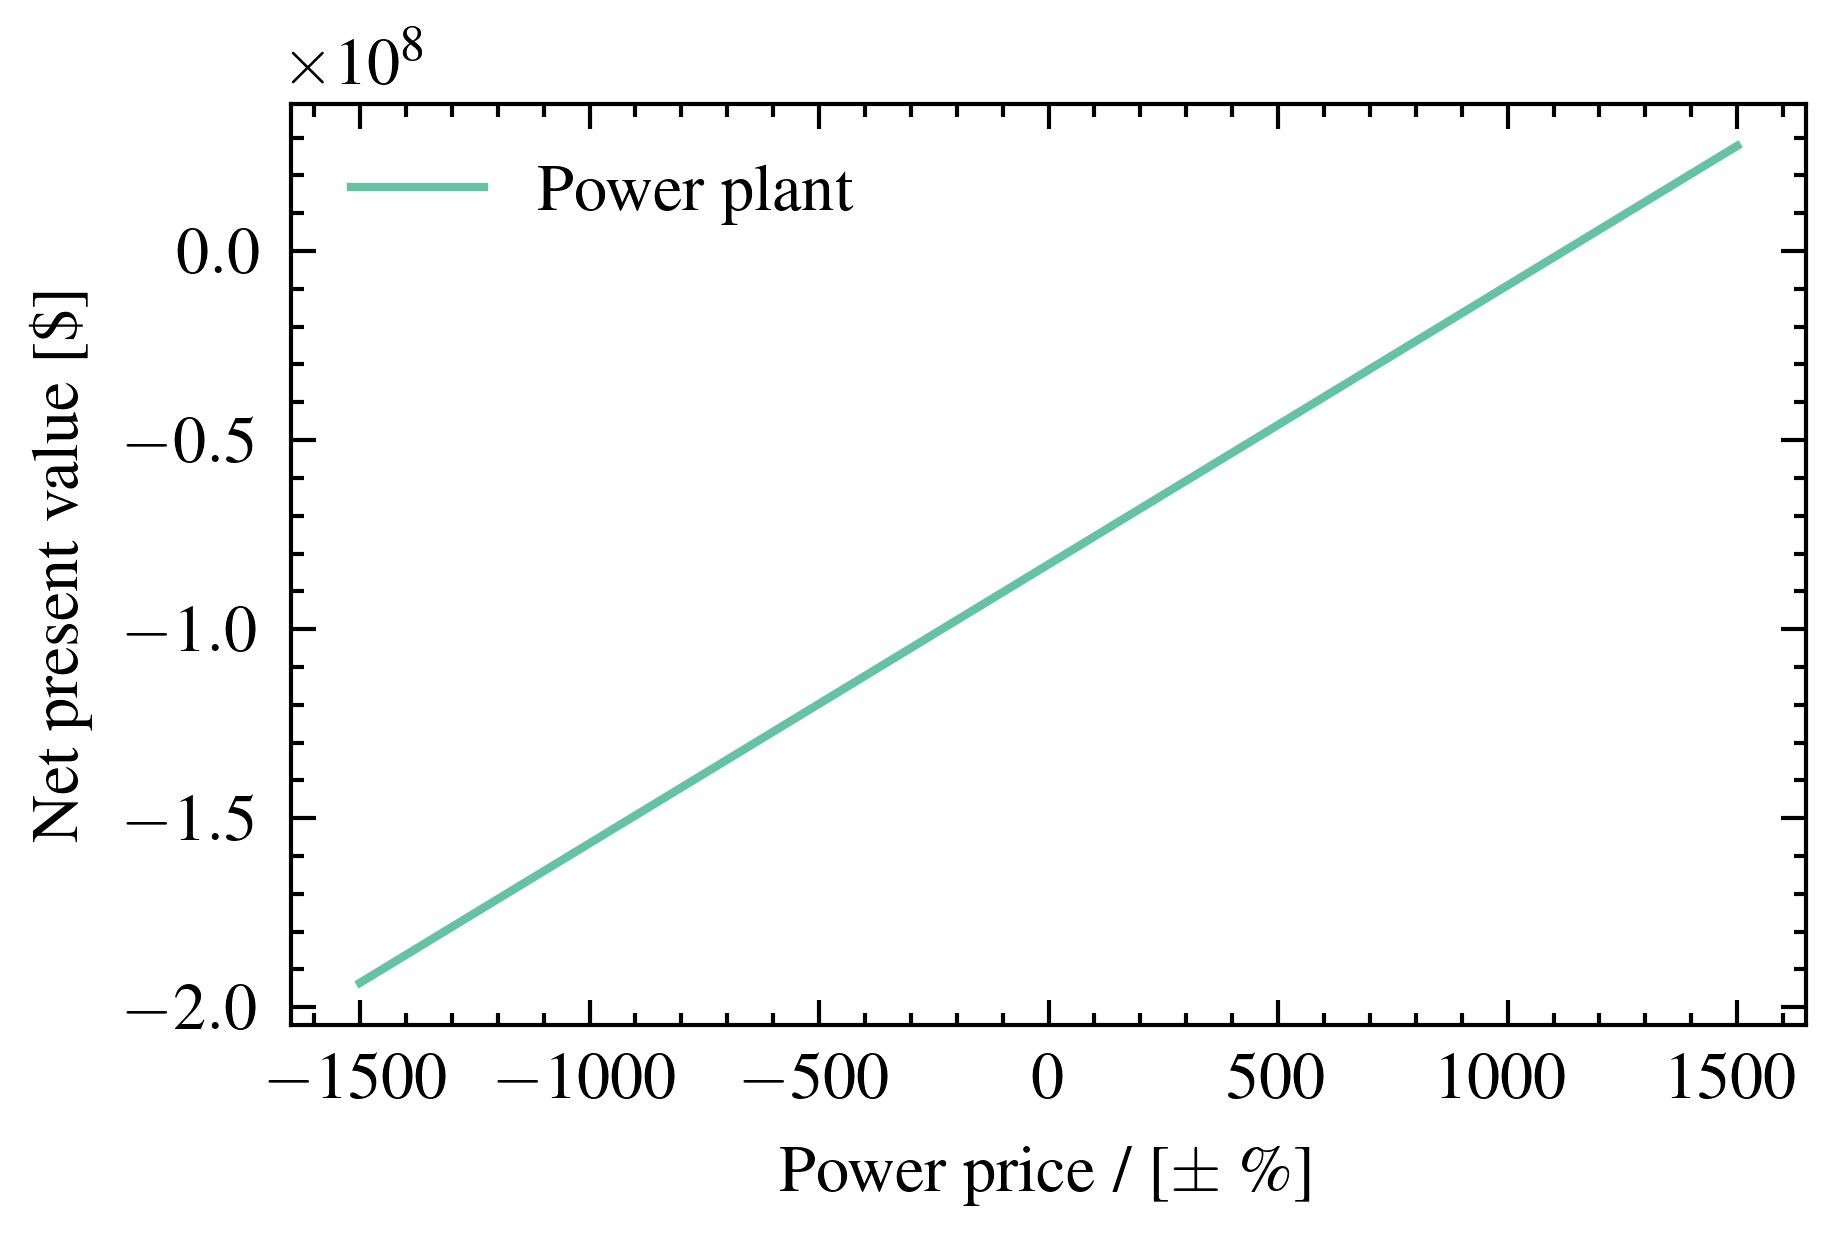

In [17]:
sensitivity_plot(geothermal_power_plant,'power', 15, metric="NPV") # To include additional capex in the PBT sensitivity, we need to set additional_capex=True

<p style='text-align: justify;'> Here, we observe that the NPV becomes positive only when the electricity selling price is approximately ten times higher than the base price. Such a price level is unrealistically high, indicating that the project is not economically feasible under any plausible market conditions.</p>

## References

[1] (1) Assa, E. Geothermal Energy for Heat and Power Production in South Holland. Master thesis, Delft University of Technology, 2025. https://repository.tudelft.nl/record/uuid:4bdedf9f-815b-40d1-8cf4-e544d7025080 (accessed 2025-12-15).